## 전이 학습
일반적으로 합성곱 신경망 기반의 딥러닝 모델을 제대로 훈련시키려면 많은 양의 데이터가 필요합니다. 그런데 불행히도 충분히 큰 데이터셋을 얻는 것은 쉽지 않습니다. 큰 데이터셋을 확보하려면 많은 돈과 시간이 필요하기 때문입니다.

이러한 현실적인 어려움을 해결한 것이 전이 학습(Transfer learning)입니다. 전이 학습이란 이미지넷(ImageNet)처럼 `아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용`하는 것을 의미합니다. 이때 아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델(네트워크)이라고 합니다. 결과적으로 비교적 적은 수의 데이터를 가지고도 우리가 원하는 과제를 해결할 수 있습니다.

![](../Static/200.jpg)  

전이 학습을 위한 방법으로는 특성 추출과 미세 조정 기법이 있습니다. 특성 추출 기법부터 하나씩 살펴보겠습니다.

### 특성 추출 기법
특성 추출(feature extractor)은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듭니다. 즉, 학습할 때는 마지막 완전연결층(이미지의 카테고리를 결정하는 부분)만 학습하고 나머지 계층들은 학습되지 않도록 합니다.

특성 추출은 이미지 분류를 위해 두 부분으로 구성됩니다.

* `합성곱층` : 합성곱층과 풀링층으로 구성
* `데이터 분류기(완전연결층)` : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층(가중치 고정)에 새로운 데이터를 통과시키고, 그 출력을 데이터 분류기에서 훈련시킵니다.

여기에서 사용 가능한 이미지 분류 모델은 다음과 같습니다.

* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

![](../Static/201.jpg)  


특성 추출에 대해 예시를 진행하기에 앞서 필요한 라이브러리를 설치합니다.

```bash
pip install opencv-python
```

`OpenCV`는 Open Source Computer Vision Library의 약어로 오픈 소스 컴퓨터 비전 라이브러리입니다. 특히 OpenCV-Python 라이브러리를 설치하면 파이썬에서도 사용이 가능합니다.

먼저 필요한 모든 라이브러리를 호출합니다.

In [19]:
import os
import time
import copy
import glob
import cv2
import shutil

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models ## 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

예제에서 사용할 이미지 데이터에 대한 전처리 방법을 정의합니다.

In [38]:
data_path = './data/train' #이미지 데이터가 위치한 경로 지정

transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)

print(len(train_dataset))


25000


* `torchvision.transform`은 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환해 줍니다. 이때 사용되는 파라미터는 다음과 같습니다.  
    ![](../Static/203_1.jpg)  
    * `Resize` : 이미지의 크기를 조정, 즉 256 x 256 크기로 이미지 데이터를 조정합니다.
    * `RandomResizedCrop` : 이미지를 랜덤한 크기 및 비율로 자릅니다.

    `Resize`와 `RandomResizedCrop` 모두 이미지를 자르는데 사용하지만 그 용도는 다릅니다. Resize가 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정이라면, RandomResizedCrop은 이미지를 랜덤한 비율로 자른 후 데이터 크기를 조정합니다.

* `RandomHorizontalFlip` : 이미지를 랜덤하게 수평으로 뒤집습니다.

* `ToTensor` : 이미지 데이터를 텐서로 변환합니다.

* `datasets.ImageFolder`는 데이터로더가 데이터를 불러올 대상(혹은 경로)과 방법(transform 혹은 전처리)를 정의하며, 파라미터는 다음과 같습니다.

    ![](../Static/203_2.jpg)  

    * `첫 번째 파라미터` : 불러올 데이터가 위치한 경로

    * `transform` : 이미지 데이터에 대한 전처리

* `DataLoader`는 데이터를 불러오는 부분으로 앞에서 정의한 ImageFolder(train_dataset)을 데이터로더에 할당하는데, 이때 한 번에 불러올 데이터양을 결정하는 `batch_size`를 지정합니다. 또한, 추가적으로 데이터를 무작위로 섞을(Shuffle) 것인지도 설정합니다. 데이터로더에서 사용하는 파라미터는 다음과 같습니다.  
    ![](../Static/204.jpg)  
    * `첫 번째 파라미터` : 데이터셋을 지정합니다.

    * `batch_size` : 한 번에 불러올 데이터양을 결정하는 배치 크기를 설정합니다.

    * `num_workers` : 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정하는데, 이때 너무 많은 프로세스를 설정하게 되면 오류가 발생하거나 메모리 부족 현상이 발생할 수 있습니다.

    * `shuffle` : 데이터를 무작위로 섞을지를 지정합니다. `shuffle = True`로 설정하면 데이터를 무작위로 섞어서 랜덤으로 불러옵니다.

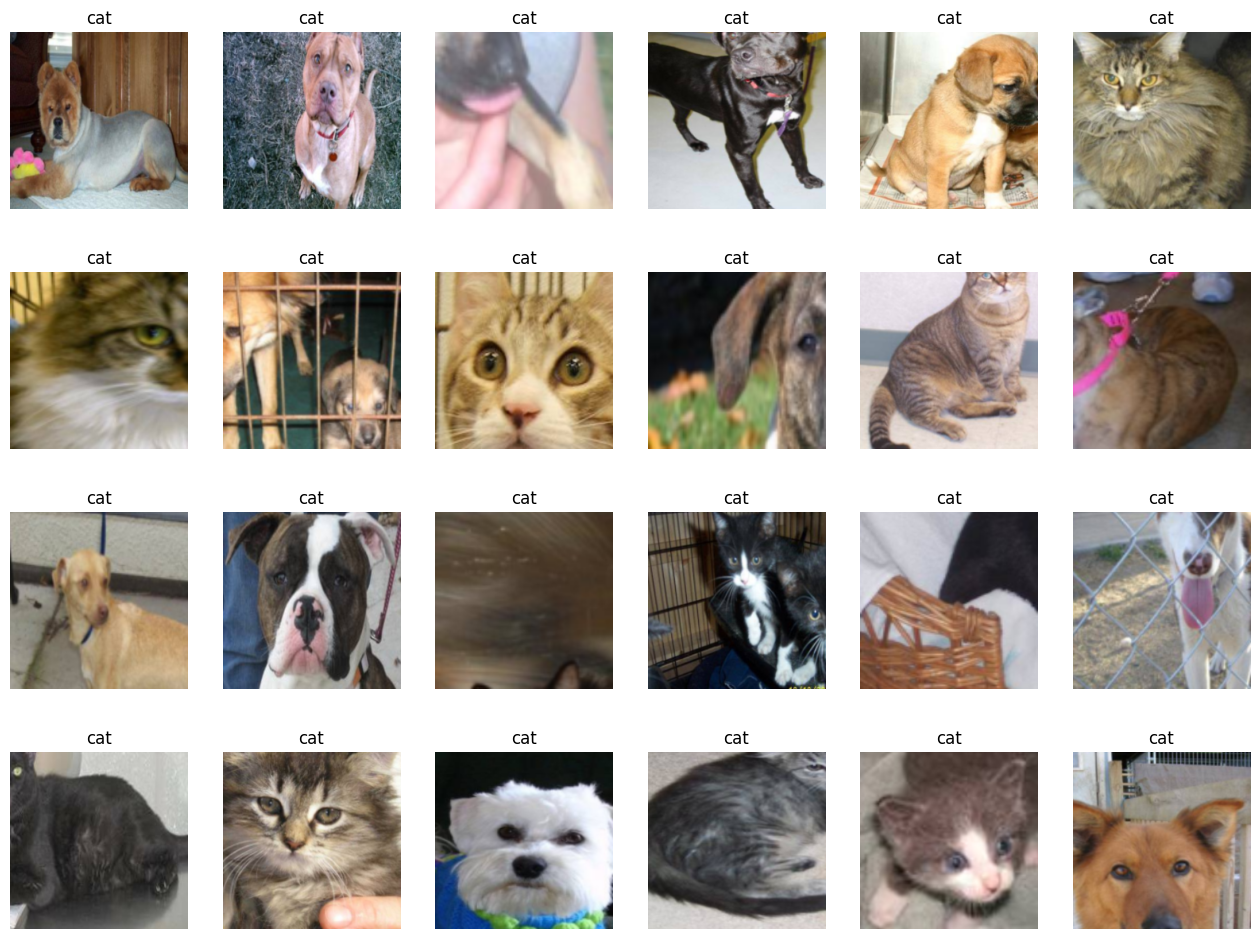

In [44]:
samples, labels = next(iter(train_loader))
classes = {0: 'cat', 1: 'dog'}
fig = plt.figure(figsize=(16, 24))

for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
